In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = '*'
os.environ['KAGGLE_KEY'] = '*'

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:51<00:00, 23.5MB/s]
100% 1.03G/1.03G [00:51<00:00, 21.2MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('asl-alphabet.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import os
import shutil
import string

directory_path = '/content/asl_alphabet_train/asl_alphabet_train'  
for sn in string.ascii_uppercase:
    sp = os.path.join(directory_path, sn)  
    shutil.rmtree(sp) 


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import random

In [ ]:
data_directory = "/content/asl_alphabet_train/asl_alphabet_train"
td = "/content/train"
vd = "/content/validation"
ttd = "/content/test"

os.makedirs(td, exist_ok=True)
os.makedirs(vd, exist_ok=True)
os.makedirs(ttd, exist_ok=True)

for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)
    tsd = os.path.join(td, folder_name)
    vsd = os.path.join(vd, folder_name)
    ttsd = os.path.join(ttd, folder_name)
    os.makedirs(tsd, exist_ok=True)
    os.makedirs(vsd, exist_ok=True)
    os.makedirs(ttsd, exist_ok=True)
    file_list = os.listdir(folder_path)
    random.shuffle(file_list)
    num_files = len(file_list)
    num_train = int(0.7 * num_files)
    num_val = int(0.1 * num_files)
    num_test = int(0.2 * num_files)
    train_files = file_list[:num_train]
    val_files = file_list[num_train:num_train+num_val]
    test_files = file_list[num_train+num_val:num_train+num_val+num_test]
    for file_name in train_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(tsd, file_name)
        shutil.move(src_path, dst_path) 
    for file_name in val_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(vsd, file_name)
        shutil.move(src_path, dst_path)
    for file_name in test_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(ttsd, file_name)
        shutil.move(src_path, dst_path)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64
PATH = 'model.pth'

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [ ]:
train_dataset = ImageFolder('/content/train', transform=transforms)
validation_dataset = ImageFolder('/content/validation', transform=transforms)
test_dataset = ImageFolder('/content/test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import torchvision as torchvision
model = torchvision.models.resnet18(pretrained=False).to(device)
model.fc = nn.Linear(model.fc.in_features, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_loader)
    epoch_training_accuracy = running_training_accuracy / len(train_loader.dataset)
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy))
    torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [50/99], Loss: 0.12327529489994049
Epoch [1/10], Training Loss: 0.3446837766190069, Training Accuracy: 0.8465079069137573
Epoch [2/10], Step [50/99], Loss: 0.05145808309316635
Epoch [2/10], Training Loss: 0.047575098518846615, Training Accuracy: 0.9844443798065186
Epoch [3/10], Step [50/99], Loss: 0.005882877856492996
Epoch [3/10], Training Loss: 0.012611856756113338, Training Accuracy: 0.9965078830718994
Epoch [4/10], Step [50/99], Loss: 0.024951275438070297
Epoch [4/10], Training Loss: 0.011580353439903131, Training Accuracy: 0.9966666102409363
Epoch [5/10], Step [50/99], Loss: 0.0006765840807929635
Epoch [5/10], Training Loss: 0.005203897081729438, Training Accuracy: 0.9985713958740234
Epoch [6/10], Step [50/99], Loss: 6.27415647613816e-05
Epoch [6/10], Training Loss: 0.0002511123616156942, Training Accuracy: 0.9999999403953552
Epoch [7/10], Step [50/99], Loss: 7.83187715569511e-05
Epoch [7/10], Training Loss: 0.00015810466615992922, Training Accuracy: 0.999999940

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.to('cuda')


model = torch.nn.Sequential(*(list(model.children())[:-1]))

model.eval()


features = []
labels = []
for images, target in train_loader:
    images = images.to('cuda')
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_features = tsne.fit_transform(features)

target_names = list(train_dataset.class_to_idx.keys())


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6300 samples in 0.002s...
[t-SNE] Computed neighbors for 6300 samples in 1.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6300
[t-SNE] Computed conditional probabilities for sample 2000 / 6300
[t-SNE] Computed conditional probabilities for sample 3000 / 6300
[t-SNE] Computed conditional probabilities for sample 4000 / 6300
[t-SNE] Computed conditional probabilities for sample 5000 / 6300
[t-SNE] Computed conditional probabilities for sample 6000 / 6300
[t-SNE] Computed conditional probabilities for sample 6300 / 6300
[t-SNE] Mean sigma: 1.285466
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.927574
[t-SNE] KL divergence after 1000 iterations: 0.850472


<ipython-input-17-111e6578e571>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


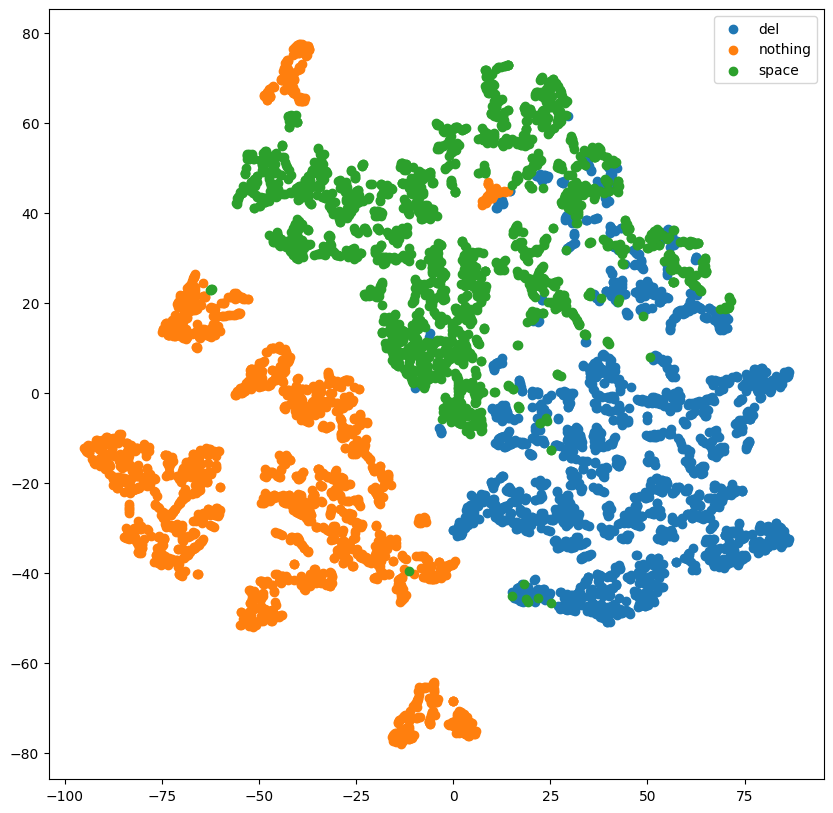

In [ ]:
cmap = plt.cm.get_cmap('tab10')
plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    indices = labels == i
    color = cmap(i)  
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], color=color, label=target_name)
plt.legend()
plt.show()